In [1]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)

import pandas as pd
pd.reset_option('all')

import polars as pl
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score

import numpy as np

# def create_model(train, old_train, quests, targets, models: dict, results: list, is_cv):
#     kol_quest = len(quests)
#     cate_cols = train.dtypes[train.dtypes == 'object'].index.tolist()
#     # ALL_USERS = train.index.unique()
#     # print('We will train with', len(ALL_USERS) ,'users info')
#     if is_cv:
#         print('using CV...')
#     else:
#         print('using hold-out...')

#     print(f'Using {len(train.columns)} columns')
#     # ITERATE THRU QUESTIONS
#     for q in quests:   
#         print('Question', q)     
#         train_q = feature_quest(train, old_train, q)
        
#         # TRAIN DATA
#         train_x = train_q
#         train_users = train_x.index.values
#         train_y = targets.loc[targets.q==q].set_index('session').loc[train_users]

#         # TRAIN MODEL - CV
#         if is_cv:
#             gkf = GroupKFold(n_splits=5)
#             f1_list, precision_list, recall_list = [], [], []
#             print('Fold:', end= '')
#             for k, (train_idx, val_idx) in enumerate(gkf.split(train_x, groups = train_users)):
#                 print(k+1, end=' ')
                
#                 X_train = train_x.iloc[train_idx]
#                 X_val = train_x.iloc[val_idx]

#                 y_train = train_y.iloc[train_idx]['correct']
#                 y_val = train_y.iloc[val_idx]['correct'].values

#                 model = CatBoostClassifier(
#                     # n_estimators = 300,
#                     # learning_rate= 0.045,
#                     # depth = 6,
#                     devices='GPU',
#                     # n_estimators=1, depth=1
#                 )
                
#                 model.fit(X_train, y_train, verbose=False, 
#                         cat_features = cate_cols)
                
#                 # SAVE MODEL
#                 models[(k, q)] = model #fold, q

#                 y_pred = model.predict_proba(X_val)[:,1]
                
#                 # scores
#                 f1 = f1_score(y_val, y_pred > 0.5, average='macro')
#                 precision = precision_score(y_val, y_pred > 0.5)
#                 recall = recall_score(y_val, y_pred > 0.5)
#                 f1_list.append(f1); precision_list.append(precision); recall_list.append(recall)
#             print()
#             print(f'Question {q} - Scores after {k+1} fold: F1: {np.mean(f1_list):.5f} Precision: {np.mean(precision_list):.5f} Recall: {np.mean(recall_list):.5f}')
#             results[q - 1][0].append(y_val)
#             results[q - 1][1].append(y_pred)

#         else: # hold-out 
#             user_train, user_val = train_test_split(train_x.index.values, random_state=42)
#             X_train = train_x.loc[user_train]
#             X_val = train_x.loc[user_val]

#             y_train = train_y.loc[user_train]['correct']
#             y_val = train_y.loc[user_val]['correct'].values

#             model = CatBoostClassifier(
#                 # n_estimators = 300,
#                 # learning_rate= 0.045,
#                 # depth = 6,
#                 devices='GPU',
#                 # n_estimators=1, depth=1
#             )
            
#             model.fit(X_train, y_train, verbose=False, 
#                     cat_features = cate_cols)
            
#             # SAVE MODEL
#             models[q] = model #fold, q

#             y_pred = model.predict_proba(X_val)[:,1]
            
#             # scores
#             f1 = f1_score(y_val, y_pred > 0.5, average='macro')
#             precision = precision_score(y_val, y_pred > 0.5)
#             recall = recall_score(y_val, y_pred > 0.5)
#             print(f'Question {q} - Scores F1: {f1:.5f} Precision: {precision:.5f} Recall: {recall:.5f}')
#             results[q - 1][0].append(y_val)
#             results[q - 1][1].append(y_pred)
#     return

# First model (Catboost)
CATS = ['event_name', 'name', 'fqid', 'room_fqid', 'text_fqid']
NUMS = ['page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
        'hover_duration', 'elapsed_time_diff']
DIALOGS = ['that', 'this', 'it', 'you','find','found','Found','notebook','Wells','wells','help','need', 'Oh','Ooh','Jo', 'flag', 'can','and','is','the','to']

COLUMNS = [
    pl.col("page").cast(pl.Float32),
    (
        (pl.col("elapsed_time") - pl.col("elapsed_time").shift(1))
        .fill_null(0)
        .clip(0, 1e9)
        .over(["session_id", "level"])
        .alias("elapsed_time_diff")
    ),
    (
        (pl.col("screen_coor_x") - pl.col("screen_coor_x").shift(1))
        .abs()
        .over(["session_id", "level"])
    ),
    (
        (pl.col("screen_coor_y") - pl.col("screen_coor_y").shift(1))
        .abs()
        .over(["session_id", "level"])
    ),
    pl.col("fqid").fill_null("fqid_None"),
    pl.col("text_fqid").fill_null("text_fqid_None")
]

name_feature = ['basic', 'undefined', 'close', 'open', 'prev', 'next']
event_name_feature = ['cutscene_click', 'person_click', 'navigate_click',
       'observation_click', 'notification_click', 'object_click',
       'object_hover', 'map_hover', 'map_click', 'checkpoint',
       'notebook_click']


sub_fqid_lists = {'0-4': ['gramps',
 'wells',
 'toentry',
 'groupconvo',
 'tomap',
 'tostacks',
 'tobasement',
 'boss',
 'cs',
 'teddy',
 'tunic.historicalsociety',
 'plaque',
 'directory',
 'tunic',
 'tunic.kohlcenter',
 'plaque.face.date',
 'notebook',
 'tunic.hub.slip',
 'tocollection',
 'tunic.capitol_0',
 'photo',
 'intro',
 'retirement_letter',
 'togrampa',
 'janitor',
 'chap1_finale',
 'report',
 'outtolunch',
 'chap1_finale_c',
 'block_0',
 'doorblock',
 'tocloset',
 'block_tomap2',
 'block_tocollection',
 'block_tomap1'],
                  '5-12': ['worker',
 'archivist',
 'gramps',
 'toentry',
 'tomap',
 'tostacks',
 'tobasement',
 'boss',
 'journals',
 'businesscards',
 'tunic.historicalsociety',
 'tofrontdesk',
 'plaque',
 'tunic.drycleaner',
 'tunic.library',
 'trigger_scarf',
 'reader',
 'directory',
 'tunic.capitol_1',
 'journals.pic_0.next',
 'tunic',
 'what_happened',
 'tunic.kohlcenter',
 'tunic.humanecology',
 'logbook',
 'businesscards.card_0.next',
 'journals.hub.topics',
 'logbook.page.bingo',
 'journals.pic_1.next',
 'reader.paper0.next',
 'trigger_coffee',
 'wellsbadge',
 'journals.pic_2.next',
 'tomicrofiche',
 'tocloset_dirty',
 'businesscards.card_bingo.bingo',
 'businesscards.card_1.next',
 'tunic.hub.slip',
 'journals.pic_2.bingo',
 'tocollection',
 'chap2_finale_c',
 'tunic.capitol_0',
 'photo',
 'reader.paper1.next',
 'businesscards.card_bingo.next',
 'reader.paper2.bingo',
 'magnify',
 'janitor',
 'tohallway',
 'outtolunch',
 'reader.paper2.next',
 'door_block_talk',
 'block_magnify',
 'reader.paper0.prev',
 'block',
 'block_0',
 'door_block_clean',
 'reader.paper2.prev',
 'reader.paper1.prev',
 'block_badge',
 'block_badge_2',
 'block_1'],
                  '13-22': ['worker',
 'gramps',
 'wells',
 'toentry',
 'confrontation',
 'crane_ranger',
 'flag_girl',
 'tomap',
 'tostacks',
 'tobasement',
 'archivist_glasses',
 'boss',
 'journals',
 'seescratches',
 'groupconvo_flag',
 'teddy',
 'expert',
 'businesscards',
 'ch3start',
 'tunic.historicalsociety',
 'tofrontdesk',
 'savedteddy',
 'plaque',
 'glasses',
 'tunic.drycleaner',
 'reader_flag',
 'tunic.library',
 'tracks',
 'tunic.capitol_2',
 'reader',
 'directory',
 'tunic.capitol_1',
 'journals.pic_0.next',
 'unlockdoor',
 'tunic',
 'tunic.kohlcenter',
 'tunic.humanecology',
 'colorbook',
 'logbook',
 'businesscards.card_0.next',
 'journals.hub.topics',
 'journals.pic_1.next',
 'journals_flag',
 'reader.paper0.next',
 'tracks.hub.deer',
 'reader_flag.paper0.next',
 'journals.pic_2.next',
 'tomicrofiche',
 'journals_flag.pic_0.bingo',
 'tocloset_dirty',
 'businesscards.card_1.next',
 'tunic.wildlife',
 'tunic.hub.slip',
 'tocage',
 'journals.pic_2.bingo',
 'tocollectionflag',
 'tocollection',
 'chap4_finale_c',
 'lockeddoor',
 'journals_flag.hub.topics',
 'reader_flag.paper2.bingo',
 'photo',
 'tunic.flaghouse',
 'reader.paper1.next',
 'directory.closeup.archivist',
 'businesscards.card_bingo.next',
 'remove_cup',
 'journals_flag.pic_0.next',
 'coffee',
 'key',
 'reader_flag.paper1.next',
 'tohallway',
 'outtolunch',
 'journals_flag.hub.topics_old',
 'journals_flag.pic_1.next',
 'reader.paper2.next',
 'reader_flag.paper2.next',
 'journals_flag.pic_1.bingo',
 'journals_flag.pic_2.next',
 'journals_flag.pic_2.bingo',
 'reader.paper0.prev',
 'reader_flag.paper0.prev',
 'reader.paper2.prev',
 'reader.paper1.prev',
 'reader_flag.paper2.prev',
 'reader_flag.paper1.prev',
 'journals_flag.pic_0_old.next',
 'journals_flag.pic_1_old.next',
 'block_nelson',
 'journals_flag.pic_2_old.next',
 'need_glasses',
 'fox'],
                 }

sub_room_lists = {'0-4': ['tunic.historicalsociety.entry',
 'tunic.historicalsociety.stacks',
 'tunic.historicalsociety.basement',
 'tunic.kohlcenter.halloffame',
 'tunic.historicalsociety.collection',
 'tunic.historicalsociety.closet',
 'tunic.capitol_0.hall'],
                  '5-12': ['tunic.historicalsociety.entry',
 'tunic.library.frontdesk',
 'tunic.historicalsociety.frontdesk',
 'tunic.historicalsociety.stacks',
 'tunic.historicalsociety.closet_dirty',
 'tunic.humanecology.frontdesk',
 'tunic.historicalsociety.basement',
 'tunic.kohlcenter.halloffame',
 'tunic.library.microfiche',
 'tunic.drycleaner.frontdesk',
 'tunic.historicalsociety.collection',
 'tunic.capitol_1.hall',
 'tunic.capitol_0.hall'],
                  '13-22': ['tunic.historicalsociety.entry',
 'tunic.wildlife.center',
 'tunic.historicalsociety.cage',
 'tunic.library.frontdesk',
 'tunic.historicalsociety.frontdesk',
 'tunic.historicalsociety.stacks',
 'tunic.historicalsociety.closet_dirty',
 'tunic.humanecology.frontdesk',
 'tunic.historicalsociety.basement',
 'tunic.kohlcenter.halloffame',
 'tunic.library.microfiche',
 'tunic.drycleaner.frontdesk',
 'tunic.historicalsociety.collection',
 'tunic.flaghouse.entry',
 'tunic.historicalsociety.collection_flag',
 'tunic.capitol_1.hall',
 'tunic.capitol_2.hall'],
                 }


sub_text_lists = {'0-4': ['tunic.historicalsociety.entry.groupconvo',
 'tunic.historicalsociety.collection.cs',
 'tunic.historicalsociety.collection.gramps.found',
 'tunic.historicalsociety.closet.gramps.intro_0_cs_0',
 'tunic.historicalsociety.closet.teddy.intro_0_cs_0',
 'tunic.historicalsociety.closet.intro',
 'tunic.historicalsociety.closet.retirement_letter.hub',
 'tunic.historicalsociety.collection.tunic.slip',
 'tunic.kohlcenter.halloffame.plaque.face.date',
 'tunic.kohlcenter.halloffame.togrampa',
 'tunic.historicalsociety.collection.gramps.lost',
 'tunic.historicalsociety.closet.notebook',
 'tunic.historicalsociety.basement.janitor',
 'tunic.historicalsociety.stacks.outtolunch',
 'tunic.historicalsociety.closet.photo',
 'tunic.historicalsociety.collection.tunic',
 'tunic.historicalsociety.closet.teddy.intro_0_cs_5',
 'tunic.historicalsociety.entry.wells.talktogramps',
 'tunic.historicalsociety.entry.boss.talktogramps',
 'tunic.historicalsociety.closet.doorblock',
 'tunic.historicalsociety.entry.block_tomap2',
 'tunic.historicalsociety.entry.block_tocollection',
 'tunic.historicalsociety.entry.block_tomap1',
 'tunic.historicalsociety.collection.gramps.look_0',
 'tunic.kohlcenter.halloffame.block_0',
 'tunic.capitol_0.hall.chap1_finale_c',
 'tunic.historicalsociety.entry.gramps.hub'],
               '5-12': ['tunic.historicalsociety.frontdesk.archivist.newspaper',
 'tunic.historicalsociety.frontdesk.archivist.have_glass',
 'tunic.drycleaner.frontdesk.worker.hub',
 'tunic.historicalsociety.closet_dirty.gramps.news',
 'tunic.humanecology.frontdesk.worker.intro',
 'tunic.library.frontdesk.worker.hello',
 'tunic.library.frontdesk.worker.wells',
 'tunic.historicalsociety.frontdesk.archivist.hello',
 'tunic.historicalsociety.closet_dirty.trigger_scarf',
 'tunic.drycleaner.frontdesk.worker.done',
 'tunic.historicalsociety.closet_dirty.what_happened',
 'tunic.historicalsociety.stacks.journals.pic_2.bingo',
 'tunic.humanecology.frontdesk.worker.badger',
 'tunic.historicalsociety.closet_dirty.trigger_coffee',
 'tunic.drycleaner.frontdesk.logbook.page.bingo',
 'tunic.library.microfiche.reader.paper2.bingo',
 'tunic.historicalsociety.closet_dirty.gramps.helpclean',
 'tunic.historicalsociety.frontdesk.archivist.have_glass_recap',
 'tunic.historicalsociety.frontdesk.magnify',
 'tunic.humanecology.frontdesk.businesscards.card_bingo.bingo',
 'tunic.library.frontdesk.wellsbadge.hub',
 'tunic.capitol_1.hall.boss.haveyougotit',
 'tunic.historicalsociety.basement.janitor',
 'tunic.historicalsociety.closet_dirty.photo',
 'tunic.historicalsociety.stacks.outtolunch',
 'tunic.library.frontdesk.worker.wells_recap',
 'tunic.capitol_0.hall.boss.talktogramps',
 'tunic.historicalsociety.closet_dirty.gramps.archivist',
 'tunic.historicalsociety.closet_dirty.door_block_talk',
 'tunic.historicalsociety.frontdesk.archivist.need_glass_0',
 'tunic.historicalsociety.frontdesk.block_magnify',
 'tunic.historicalsociety.frontdesk.archivist.foundtheodora',
 'tunic.historicalsociety.closet_dirty.gramps.nothing',
 'tunic.historicalsociety.closet_dirty.door_block_clean',
 'tunic.library.frontdesk.worker.hello_short',
 'tunic.historicalsociety.stacks.block',
 'tunic.historicalsociety.frontdesk.archivist.need_glass_1',
 'tunic.historicalsociety.frontdesk.archivist.newspaper_recap',
 'tunic.drycleaner.frontdesk.worker.done2',
 'tunic.humanecology.frontdesk.block_0',
 'tunic.library.frontdesk.worker.preflag',
 'tunic.drycleaner.frontdesk.worker.takealook',
 'tunic.library.frontdesk.worker.droppedbadge',
 'tunic.library.microfiche.block_0',
 'tunic.library.frontdesk.block_badge',
 'tunic.library.frontdesk.block_badge_2',
 'tunic.capitol_1.hall.chap2_finale_c',
 'tunic.drycleaner.frontdesk.block_0',
 'tunic.humanecology.frontdesk.block_1',
 'tunic.drycleaner.frontdesk.block_1'],
               '13-22': ['tunic.historicalsociety.cage.confrontation',
 'tunic.wildlife.center.crane_ranger.crane',
 'tunic.wildlife.center.wells.nodeer',
 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation',
 'tunic.historicalsociety.basement.seescratches',
 'tunic.flaghouse.entry.flag_girl.hello',
 'tunic.historicalsociety.basement.ch3start',
 'tunic.historicalsociety.entry.groupconvo_flag',
 'tunic.historicalsociety.collection_flag.gramps.flag',
 'tunic.historicalsociety.basement.savedteddy',
 'tunic.library.frontdesk.worker.nelson',
 'tunic.wildlife.center.expert.removed_cup',
 'tunic.library.frontdesk.worker.flag',
 'tunic.historicalsociety.entry.boss.flag',
 'tunic.flaghouse.entry.flag_girl.symbol',
 'tunic.wildlife.center.wells.animals',
 'tunic.historicalsociety.cage.glasses.afterteddy',
 'tunic.historicalsociety.cage.teddy.trapped',
 'tunic.historicalsociety.cage.unlockdoor',
 'tunic.historicalsociety.stacks.journals.pic_2.bingo',
 'tunic.historicalsociety.entry.wells.flag',
 'tunic.humanecology.frontdesk.worker.badger',
 'tunic.historicalsociety.stacks.journals_flag.pic_0.bingo',
 'tunic.historicalsociety.entry.directory.closeup.archivist',
 'tunic.capitol_2.hall.boss.haveyougotit',
 'tunic.wildlife.center.wells.nodeer_recap',
 'tunic.historicalsociety.cage.glasses.beforeteddy',
 'tunic.wildlife.center.expert.recap',
 'tunic.historicalsociety.stacks.journals_flag.pic_1.bingo',
 'tunic.historicalsociety.cage.lockeddoor',
 'tunic.historicalsociety.stacks.journals_flag.pic_2.bingo',
 'tunic.wildlife.center.remove_cup',
 'tunic.wildlife.center.tracks.hub.deer',
 'tunic.historicalsociety.frontdesk.key',
 'tunic.library.microfiche.reader_flag.paper2.bingo',
 'tunic.flaghouse.entry.colorbook',
 'tunic.wildlife.center.coffee',
 'tunic.historicalsociety.collection_flag.gramps.recap',
 'tunic.wildlife.center.wells.animals2',
 'tunic.flaghouse.entry.flag_girl.symbol_recap',
 'tunic.historicalsociety.closet_dirty.photo',
 'tunic.historicalsociety.stacks.outtolunch',
 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap',
 'tunic.historicalsociety.entry.boss.flag_recap',
 'tunic.capitol_1.hall.boss.writeitup',
 'tunic.library.frontdesk.worker.nelson_recap',
 'tunic.historicalsociety.entry.wells.flag_recap',
 'tunic.drycleaner.frontdesk.worker.done2',
 'tunic.library.frontdesk.worker.flag_recap',
 'tunic.library.frontdesk.worker.preflag',
 'tunic.historicalsociety.basement.gramps.seeyalater',
 'tunic.flaghouse.entry.flag_girl.hello_recap',
 'tunic.historicalsociety.basement.gramps.whatdo',
 'tunic.library.frontdesk.block_nelson',
 'tunic.historicalsociety.cage.need_glasses',
 'tunic.capitol_2.hall.chap4_finale_c',
 'tunic.wildlife.center.fox.concern']
              }


SUB_LEVELS = {'0-4': [1, 2, 3, 4],
              '5-12': [5, 6, 7, 8, 9, 10, 11, 12],
              '13-22': [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]}
level_groups = ["0-4", "5-12", "13-22"]


def feature_engineer(x, grp, use_extra, feature_suffix):
    LEVELS = SUB_LEVELS[grp]
    text_lists = sub_text_lists[grp]
    room_lists = sub_room_lists[grp]
    fqid_lists = sub_fqid_lists[grp]
    aggs = [
        pl.col("index").count().alias(f"session_number_{feature_suffix}"),

        *[pl.col('index').filter(pl.col('text').str.contains(c)).count().alias(f'word_{c}') for c in DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).mean().alias(f'word_mean_{c}') for c in
          DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).std().alias(f'word_std_{c}') for c in
          DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).max().alias(f'word_max_{c}') for c in
          DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).sum().alias(f'word_sum_{c}') for c in
          DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).median().alias(f'word_median_{c}') for c
          in DIALOGS],

        *[pl.col(c).drop_nulls().n_unique().alias(f"{c}_unique_{feature_suffix}") for c in CATS],

        *[pl.col(c).mean().alias(f"{c}_mean_{feature_suffix}") for c in NUMS],
        *[pl.col(c).std().alias(f"{c}_std_{feature_suffix}") for c in NUMS],
        *[pl.col(c).min().alias(f"{c}_min_{feature_suffix}") for c in NUMS],
        *[pl.col(c).max().alias(f"{c}_max_{feature_suffix}") for c in NUMS],
        *[pl.col(c).median().alias(f"{c}_median_{feature_suffix}") for c in NUMS],

        *[pl.col("fqid").filter(pl.col("fqid") == c).count().alias(f"{c}_fqid_counts{feature_suffix}")
          for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
          c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
          c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).median().alias(f"{c}_ET_median_{feature_suffix}") for
          c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in fqid_lists],

        *[pl.col("text_fqid").filter(pl.col("text_fqid") == c).count().alias(f"{c}_text_fqid_counts{feature_suffix}")
          for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).median().alias(f"{c}_ET_median_{feature_suffix}")
          for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in text_lists],

        *[pl.col("room_fqid").filter(pl.col("room_fqid") == c).count().alias(f"{c}_room_fqid_counts{feature_suffix}")
          for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).median().alias(f"{c}_ET_median_{feature_suffix}")
          for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in room_lists],

        *[pl.col("event_name").filter(pl.col("event_name") == c).count().alias(f"{c}_event_name_counts{feature_suffix}")
          for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}")
          for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).median().alias(
            f"{c}_ET_median_{feature_suffix}") for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in event_name_feature],

        *[pl.col("name").filter(pl.col("name") == c).count().alias(f"{c}_name_counts{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).median().alias(f"{c}_ET_median_{feature_suffix}") for
          c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in
          name_feature],

        *[pl.col("level").filter(pl.col("level") == c).count().alias(f"{c}_LEVEL_count{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c
          in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).median().alias(f"{c}_ET_median_{feature_suffix}") for
          c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in
          LEVELS],

        *[pl.col("level_group").filter(pl.col("level_group") == c).count().alias(
            f"{c}_LEVEL_group_count{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
          c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}")
          for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).median().alias(
            f"{c}_ET_median_{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in
          level_groups],

    ]
    # df = x.groupby(['session_id']).agg(aggs).sort_values("session_id")

    df = x.with_columns(COLUMNS).groupby(['session_id'], maintain_order=True).agg(aggs).sort("session_id")

    if use_extra:
        if grp == '5-12':
            aggs = [
                pl.col("elapsed_time").filter((pl.col("text") == "Here's the log book.")
                                              | (pl.col("fqid") == 'logbook.page.bingo'))
                    .apply(lambda s: s.max() - s.min()).alias("logbook_bingo_duration"),
                pl.col("index").filter(
                    (pl.col("text") == "Here's the log book.") | (pl.col("fqid") == 'logbook.page.bingo')).apply(
                    lambda s: s.max() - s.min()).alias("logbook_bingo_indexCount"),
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader')) | (
                            pl.col("fqid") == "reader.paper2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "reader_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader')) | (
                        pl.col("fqid") == "reader.paper2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "reader_bingo_indexCount"),
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals')) | (
                            pl.col("fqid") == "journals.pic_2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "journals_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals')) | (
                        pl.col("fqid") == "journals.pic_2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "journals_bingo_indexCount"),
            ]
            #tmp = x.groupby(['session_id']).agg(aggs).sort_values("session_id")

            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')

        if grp == '13-22':
            aggs = [
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader_flag')) | (
                            pl.col("fqid") == "tunic.library.microfiche.reader_flag.paper2.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("reader_flag_duration"),
                pl.col("index").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader_flag')) | (
                            pl.col("fqid") == "tunic.library.microfiche.reader_flag.paper2.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("reader_flag_indexCount"),
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals_flag')) | (
                            pl.col("fqid") == "journals_flag.pic_0.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("journalsFlag_bingo_duration"),
                pl.col("index").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals_flag')) | (
                            pl.col("fqid") == "journals_flag.pic_0.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("journalsFlag_bingo_indexCount")
            ]
            #tmp = x.groupby(['session_id']).agg(aggs).sort_values("session_id")

            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')

    return df.to_pandas()

def time_feature(train):
    train = train.reset_index()
    q = (
        pl.from_pandas(train)
          .lazy()
          .with_columns([
            pl.col("session_id").apply(lambda x: int(str(x)[:2])).alias('year'),#.astype(np.uint8)
            pl.col("session_id").apply(lambda x: int(str(x)[2:4])+1).alias('month'),#.astype(np.uint8)
            pl.col("session_id").apply(lambda x: int(str(x)[4:6])).alias('day'),#.astype(np.uint8)
            pl.col("session_id").apply(lambda x: int(str(x)[6:8])).alias('hour'),#.astype(np.uint8)
            pl.col("session_id").apply(lambda x: int(str(x)[8:10])).alias('minute'),#.astype(np.uint8)
            pl.col("session_id").apply(lambda x: int(str(x)[10:12])).alias('second'),#.astype(np.uint8)
            pl.col("session_id").apply(lambda x: int(str(x)[12:])).alias('id_anonymous'),#.astype(np.uint8)
        ])
    )
    # train["year"] = train.with_columns("session_id").apply(lambda x: int(str(x)[:2]))#.astype(np.uint8)
    # train["month"] = train["session_id"].apply(lambda x: int(str(x)[2:4])+1)#.astype(np.uint8)
    # train["day"] = train["session_id"].apply(lambda x: int(str(x)[4:6]))#.astype(np.uint8)
    # train["hour"] = train["session_id"].apply(lambda x: int(str(x)[6:8]))#.astype(np.uint8)
    # train["minute"] = train["session_id"].apply(lambda x: int(str(x)[8:10]))#.astype(np.uint8)
    # train["second"] = train["session_id"].apply(lambda x: int(str(x)[10:12]))#.astype(np.uint8)
    # train["id_anonymous"] = train["session_id"].apply(lambda x: int(str(x)[12:]))#.astype(np.uint8)
    
    # time features
    # df = pl.from_pandas(train)
    # aggs = [
    #     pl.col('session_id').apply(lambda x: int(str(x)[:2])).alias('year'),
    #     pl.col('session_id').apply(lambda x: int(str(x)[2:4])+1).alias('month'),
    #     pl.col('session_id').apply(lambda x: int(str(x)[4:6])).alias('day'),
    #     pl.col('session_id').apply(lambda x: int(str(x)[6:8])).alias('hour'),
    #     pl.col('session_id').apply(lambda x: int(str(x)[8:10])).alias('minute'),
    #     pl.col('session_id').apply(lambda x: int(str(x)[10:12])).alias('second'),
    #     pl.col('session_id').apply(lambda x: int(str(x)[12:])).alias('id_anonymous'),
    # ]

    return q.collect().to_pandas().set_index('session_id')


def new_page(X, grp):   # 여기서 더 일반적인 feature를 추출할 수 있을듯. page 0 을 들른 유저들은 new_page 0, 아닌 유저들은 1로 했는데, 그냥 조회한 page 수를 feature로 넘겨주면 되지않을까?
    '''
    X= revised_train dataset
    '''
    # 이상치 session_id 추출
    if grp == '5-12':
        session_2=X[X.page==0].session_id.unique().tolist()
        X.loc[X['session_id'].isin(session_2), 'new_page'] = 0
        X.loc[~X['session_id'].isin(session_2), 'new_page'] = 1
    
    if grp == '13-22':
        session_3=X[(X.page==0)|(X.page==1)|(X.page==2)].session_id.unique().tolist()
        X.loc[X['session_id'].isin(session_3), 'new_page'] = 0
        X.loc[~X['session_id'].isin(session_3), 'new_page'] = 1
    
    return X.groupby(['session_id']).first().reset_index()

# https://www.kaggle.com/code/glipko/recap-texts#Data-Extraction-
def text_cnt(x, revised_train):
    
    x['in_the_same_dialogue'] = x['text_fqid'].shift() # 한칸씩 뒤로
    x['in_the_same_dialogue'] = x['text_fqid'] == x['in_the_same_dialogue']

    dialogue_sequence = x[~x['in_the_same_dialogue']] # 겹치지 않는 아이들
    dialogue_sequence = dialogue_sequence[~dialogue_sequence['text_fqid'].isna()]
    dialogue_sequence = dialogue_sequence[(dialogue_sequence['event_name'] == 'observation_click') | \
                                      (dialogue_sequence['event_name'] == 'person_click')]
    dialogue_sequence = dialogue_sequence.drop(columns=['text', 'in_the_same_dialogue', 'elapsed_time'], errors='ignore')

    dialogues = x[x['event_name'] == 'person_click']['text_fqid'].unique()
    recap_dialogues = []
    for dialogue in dialogues:
        if('recap' in dialogue or 'lost' in dialogue):
            recap_dialogues.append(dialogue)


    observations = x[x['event_name'] == 'observation_click']['text_fqid'].unique()
    recap_observations = []
    for observation in observations:
        if('block' in observation):
            recap_observations.append(observation)


    dialogue_sequence = dialogue_sequence[dialogue_sequence['text_fqid'].isin(recap_observations) | \
                        dialogue_sequence['text_fqid'].isin(recap_dialogues)]

    session_event_recap = dialogue_sequence.groupby(['session_id', 'event_name']) \
                                        .size() \
                                        .reset_index() \
                                        .rename(columns={0:'recap_reading'})

    session_event_recap = session_event_recap[(session_event_recap['event_name'] == 'observation_click') | \
                    (session_event_recap['event_name'] == 'person_click')]

    session_recap = session_event_recap.groupby('session_id')['recap_reading'].sum()

    texts = x[(~x['text'].isna()) & (x['text'] != 'undefined')]
    reading = texts.groupby('session_id').size()
    text_feature=pd.concat([session_recap,reading], axis=1)
    text_feature.columns=['recap_reading', 'reading_cnt']
    
    # revised_train = pd.merge(x, revised_train, on='session_id', how='left')
    
    return pd.merge(revised_train, text_feature, on='session_id', how='left').set_index('session_id')


def feature_quest(new_train, train, q):
    train_q = new_train.copy()
    texts = {
        1: ["Yes! This cool old slip from 1916.", 
             "Go ahead, take a peek at the shirt!", 
             "I'll be at the Capitol. Let me know if you find anything!", 
             "We need to talk about that missing paperwork.", 
             "The slip is from 1916 but the team didn't start until 1974!"], 
         2: ["It's already all done!", 
             "Gramps is the best historian ever!"], 
         3: ["I suppose historians are boring, too?" 
             "Why don't you head to the Basketball Center and rustle up some clues?", 
             "We need to talk about that missing paperwork."],    
        
         4: ['I need to find the owner of this slip.',
             'She led marches and helped women get the right to vote!', 
             "Here's a call number to find more info in the Stacks.", 
             "What was Wells doing here?"],

         5: ["Your gramps is awesome! Always full of stories.",
             "Here's a call number to find more info in the Stacks.", 
             "Where did you get that coffee?"],         
        
         6: ["Oh, that's from Bean Town.", 
             "Wells? I knew it!"], 
           
         7: ["Try not to panic, Jo.",
             "I've got a stack of business cards from my favorite cleaners.",
             "Check out our microfiche. It's right through that door.", 
             "I'm afraid my papers have gone missing in this mess.", 
             "Nope. But Youmans and other suffragists worked hard to change that."], 
            
         8: ["What should I do first?",
             "Thanks to them, Wisconsin was the first state to approve votes for women!"], 

         9: [ "Can you help me? I need to find the owner of this slip.",
             'Looks like a dry cleaning receipt.',
             "I knew I could count on you, Jo!", 
             "Nope, that's from Bean Town. I only drink Holdgers!"], 

         10:["I love these photos of me and Teddy."
             'Your gramps is awesome! Always full of stories.',
             "Nope. But Youmans and other suffragists worked hard to change that.", 
             "Right outside the door.", 
             "Do you have any info on Theodora Youmans?"], 
                   
         11:["I ran into Wells there this morning",
             'Your gramps is awesome! Always full of stories.',
             "Wait a sec. Women couldn't vote?!", 
             "I've got a stack of business cards from my favorite cleaners.",
             "An old shirt? Try the university."],  
         12:[],
         13:[],        
         14:[],
         15:[],
         16:[],
         17:[],
         18:[]
        }
    i = 0
    for text in texts[q]:
        i += 1
        train_q['text' + str(i)] = train[train['text'] == text].groupby(['session_id'])['delt_time'].sum()
    
    fqids = {
         1: ['directory'], 
         2: ['notebook','chap1_finale_c'], 
         3: ['tostacks','doorblock'], 
         4: ['journals.pic_1.next', 'businesscards.card_1.next', 'block'], 
         5: ['janitor', 'journals.pic_2.next'], 
         6: ['businesscards', 'journals.pic_0.next','tobasement', 'logbook.page.bingo', 'tohallway'],  
         7: ['journals.pic_1.next','reader.paper2.bingo','businesscards.card_bingo.next', 
             'logbook.page.bingo', 'tunic.kohlcenter'],  
         8: ['reader.paper2.bingo'],  
         9: ['journals.pic_1.next','businesscards.card_bingo.bingo', 'reader'],  
         10:['tunic.kohlcenter','magnify','block','journals.pic_1.next', 'journals'], 
         11:['tostacks','block_magnify','block','businesscards.card_bingo.next'], 
         12:['businesscards.card_1.next','tofrontdesk'],  
         13:['tocloset_dirty','reader.paper1.next'], 
         14:['tracks'], 
         15:['groupconvo_flag'], 
         16:['savedteddy'], 
         17:['journals_flag.pic_0.next'], 
         18:['chap4_finale_c'], 
        }
    for fqid in fqids[q]:
        train_q['t_fqid_' + fqid] = train[train['fqid'] == fqid].groupby(['session_id'])['delt_time'].sum()

    text_fqids = {
        1:[],
        2:['tunic.historicalsociety.collection.gramps.found'],
        3:[],
        4: ['tunic.humanecology.frontdesk.worker.intro',
            'tunic.library.frontdesk.worker.wells', 
            'tunic.library.frontdesk.worker.hello'], 
        5: ['tunic.humanecology.frontdesk.worker.intro',
            'tunic.historicalsociety.closet_dirty.gramps.helpclean',
            'tunic.historicalsociety.closet_dirty.gramps.news'],     
        6: ['tunic.humanecology.frontdesk.worker.intro',
            'tunic.historicalsociety.frontdesk.archivist.foundtheodora',
            'tunic.historicalsociety.closet_dirty.trigger_coffee', 
            'tunic.historicalsociety.closet_dirty.gramps.archivist'], 
        7: ['tunic.historicalsociety.closet_dirty.door_block_talk',
            'tunic.drycleaner.frontdesk.worker.hub',
            'tunic.historicalsociety.closet_dirty.trigger_coffee'], 
        8: ['tunic.humanecology.frontdesk.worker.intro',
            'tunic.historicalsociety.frontdesk.magnify', 
            'tunic.historicalsociety.closet_dirty.trigger_coffee'], 
        9: ['tunic.historicalsociety.frontdesk.archivist.hello',
            'tunic.library.frontdesk.worker.wells', 
            'tunic.historicalsociety.frontdesk.archivist.foundtheodora'], 
        10: ['tunic.library.frontdesk.worker.wells',
            'tunic.historicalsociety.frontdesk.archivist.have_glass_recap',
             'tunic.historicalsociety.closet_dirty.gramps.news'], 
        11: ['tunic.historicalsociety.frontdesk.archivist.newspaper_recap',
             'tunic.historicalsociety.closet_dirty.gramps.archivist'], 
        12:[],
        13:['tunic.drycleaner.frontdesk.logbook.page.bingo'],
        14: ['tunic.flaghouse.entry.flag_girl.symbol_recap', 
             'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap'],
        15:['tunic.flaghouse.entry.colorbook'], 
        16:['tunic.library.frontdesk.worker.nelson'], 
        17:['tunic.historicalsociety.entry.wells.flag'], 
        18:['tunic.flaghouse.entry.flag_girl.symbol_recap'], 
    }
    for text_fqid in text_fqids[q]:
        maska = train['text_fqid'] == text_fqid
        train_q['t_text_fqid_' + text_fqid] = train[maska].groupby(['session_id'])['delt_time'].sum()       
        train_q['l_text_fqid_' + text_fqid] = train[train['text_fqid'] == text_fqid].groupby(['session_id'])['index'].count()


    room_lvls = {
         1: [['tunic.capitol_0.hall',4],['tunic.historicalsociety.collection',3],
            ['tunic.historicalsociety.entry',1],['tunic.historicalsociety.collection', 2]], 
         2: [],
         3: [['tunic.capitol_0.hall',4]], 
         4: [['tunic.historicalsociety.frontdesk',12], 
             ['tunic.historicalsociety.stacks',7]], 
         5: [['tunic.historicalsociety.stacks',12]],  
         6: [['tunic.drycleaner.frontdesk',8],  
             ['tunic.library.microfiche',9]], 
         7: [['tunic.library.frontdesk',10]], 
         8: [['tunic.kohlcenter.halloffame', 11], 
             ['tunic.kohlcenter.halloffame',6]], 
         9: [['tunic.capitol_1.hall', 12], 
             ['tunic.historicalsociety.collection',12]],
         10:[['tunic.humanecology.frontdesk',7]], 
         11:[['tunic.drycleaner.frontdesk',9], 
             ['tunic.historicalsociety.collection',6]], 
         12:[['tunic.historicalsociety.stacks',6],
             ['tunic.historicalsociety.frontdesk', 7],
             ['tunic.historicalsociety.closet_dirty',11], 
             ['tunic.historicalsociety.frontdesk', 12]], 
         13:[['tunic.library.microfiche', 9], 
             ['tunic.historicalsociety.stacks', 11],
             ['tunic.library.frontdesk', 10], 
             ['tunic.historicalsociety.entry', 5]], 
         14:[['tunic.historicalsociety.closet_dirty',17],
             ['tunic.historicalsociety.entry',15]], 
         15:[['tunic.historicalsociety.entry',15],
             ['tunic.library.frontdesk',20]], 
         16:[['tunic.library.frontdesk', 20],
             ['tunic.wildlife.center',19]], 
         17:[['tunic.wildlife.center', 19],
             ['tunic.historicalsociety.stacks', 21]], 
         18:[['tunic.wildlife.center', 22]], 
        }
    for rl in room_lvls[q]:
        nam = rl[0]+str(rl[1])
        maska = (train['room_fqid'] == rl[0])&(train['level'] == rl[1])
        train_q['t_' + nam] = train[maska].groupby(['session_id'])['delt_time'].sum()
        train_q['l_' + nam] = train[maska].groupby(['session_id'])['index'].count()

    return train_q

def load_targets(args):
    targets = pd.read_csv(args.target)
    targets["session"] = targets["session_id"].str.split("_",expand = True)[0]
    targets["session"] = targets["session"].astype(int)
    targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
    return targets

def delt_time_def(df):
    df.sort_values(by=['session_id', 'elapsed_time'], inplace=True)
    df['d_time'] = df['elapsed_time'].diff(1)
    df['d_time'].fillna(0, inplace=True)
    df['delt_time'] = df['d_time'].clip(0, 103000)  
    return df


def preprocessing(df, grp):
    start, end = map(int,grp.split('-'))
    kol_lvl = (df.groupby(['session_id'])['level'].agg('nunique') < end - start + 1)
    list_session = kol_lvl[kol_lvl].index
    df = df[~df['session_id'].isin(list_session)]
    df = delt_time_def(df)
    train_ = feature_engineer(pl.from_pandas(df), grp, use_extra=False, feature_suffix='')
    # recap text count \w join
    train = text_cnt(df, train_)
    # add year, month, day etc.
    train = time_feature(train)
    
    # df = new_page(df, grp)
    
    
    
    return train, df

In [2]:
import argparse
import platform

def parse_args():

    if platform.system() == 'Linux':
        DIR = "/home/wooseok/Python_lab/kaggle/gameplay/student-gameplay-prediction/"
    elif platform.system() == 'Darwin':
        DIR = "/Users/wooseokpark/github/kaggle/student-gameplay-prediction/"

    parser = argparse.ArgumentParser()

    parser.add_argument("--target", default=DIR + "data/raw/input/train_labels.csv", type=str, help="target csv")
    parser.add_argument("--train", default=DIR + "data/raw/input/train.parquet", type=str, help="train parquet")
    parser.add_argument("--model_path", default=DIR + "boosting/models/", type=str, help="model path")
    parser.add_argument("--cv", default=1, type=int, help="using cross-validation")

    args = parser.parse_args(args=[])

    return args

In [3]:
args = parse_args()

In [4]:
targets = load_targets(args)
df = pd.read_parquet(args.train)
models = {}
results = [[[], []] for _ in range(18)]
list_q = {'0-4':[1,2,3], '5-12':[4,5,6,7,8,9,10,11,12,13], '13-22':[14,15,16,17,18]}
groups = ['0-4', '5-12', '13-22']

# for grp in groups:
#     df_grp = df[df['level_group'] == grp]
#     train = preprocessing(df_grp, grp)
#     quests = list_q[grp]
#     create_model(train, df_grp, quests, targets, models, results, args.cv)

# score_threshold(results)

# time = datetime.now().strftime("%Y%m%d%H%M%S")
# os.makedirs(args.model_path + time)
# if args.cv:
#     for k, q in models.keys():
#         models[(k,q)].save_model(args.model_path + time + '/' + f'catboost_{time}_quest{q}_fold{k}.cbm')
# else:
#     for q in models.keys():
#         models[q].save_model(args.model_path + time + '/' + f'catboost_{time}_quest{q}_holdout.cbm')

In [5]:
df

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26296941,22100221145014656,1600,5483231,navigate_click,undefined,22,NaN,343.887291,36.701026,483.0,273.0,NaN,None,None,tunic.capitol_2.hall,None,0,0,1,13-22
26296942,22100221145014656,1601,5485166,navigate_click,undefined,22,NaN,332.696070,141.493178,545.0,221.0,NaN,None,chap4_finale_c,tunic.capitol_2.hall,None,0,0,1,13-22
26296943,22100221145014656,1602,5485917,navigate_click,undefined,22,NaN,369.912859,140.569205,611.0,217.0,NaN,None,None,tunic.capitol_2.hall,None,0,0,1,13-22
26296944,22100221145014656,1603,5486753,navigate_click,undefined,22,NaN,252.299653,123.805889,526.0,232.0,NaN,None,chap4_finale_c,tunic.capitol_2.hall,None,0,0,1,13-22


In [77]:
import pickle
null_dict = {}
for grp in groups:
    df_grp = df[df['level_group'] == grp]
    train, old_train = preprocessing(df_grp, grp)
    quests = list_q[grp]


    # null over 0.7 features
    null_cols = train.isna().sum()[train.isna().sum() / len(train) > 0.7].index.values
    null_dict[grp] = null_cols
with open('../boosting/processed/null_feat.npy', 'wb') as f:
    pickle.dump(null_dict, f)

In [78]:
with open('../boosting/processed/null_feat.npy', 'rb') as f:
    nd = pickle.load(f)
nd

{'0-4': array(['word_mean_found', 'word_mean_wells', 'word_mean_Oh',
        'word_mean_flag', 'word_std_found', 'word_std_wells',
        'word_std_Oh', 'word_std_flag', 'word_max_found', 'word_max_wells',
        'word_max_Oh', 'word_max_flag', 'word_sum_found', 'word_sum_wells',
        'word_sum_Oh', 'word_sum_flag', 'word_median_found',
        'word_median_wells', 'word_median_Oh', 'word_median_flag',
        'boss_ET_std_', 'tunic.historicalsociety_ET_std_',
        'directory_ET_std_', 'block_0_ET_std_', 'doorblock_ET_std_',
        'tocloset_ET_std_', 'block_tomap2_ET_std_',
        'block_tocollection_ET_std_', 'block_tomap1_ET_std_',
        'boss_ET_mean_', 'tunic.historicalsociety_ET_mean_',
        'directory_ET_mean_', 'block_0_ET_mean_', 'doorblock_ET_mean_',
        'tocloset_ET_mean_', 'block_tomap2_ET_mean_',
        'block_tocollection_ET_mean_', 'block_tomap1_ET_mean_',
        'boss_ET_sum_', 'tunic.historicalsociety_ET_sum_',
        'directory_ET_sum_', 'block_0

In [83]:
key

'13-22'

In [79]:
for key in nd.keys():
    print(len(nd[key]))

140
255
315


In [82]:
train.columns

Index(['session_number_', 'word_that', 'word_this', 'word_it', 'word_you',
       'word_find', 'word_found', 'word_Found', 'word_notebook', 'word_Wells',
       ...
       '13-22_ET_max_', 'recap_reading', 'reading_cnt', 'year', 'month', 'day',
       'hour', 'minute', 'second', 'id_anonymous'],
      dtype='object', length=1352)

In [14]:
## Don't execute all at once. This will crash the kernel
# train2 = preprocessing(df[df['level_group'] == '5-12'], '5-12')
# train3 = preprocessing(df[df['level_group'] == '13-22'], '13-22')

: 

: 

In [16]:
q = 1
print('Question', q)     
train_q = feature_quest(train, old_train, q)

cate_cols = train.dtypes[train.dtypes == 'object'].index.tolist()

# TRAIN DATA
train_x = train_q
train_users = train_x.index.values
train_y = targets.loc[targets.q==q].set_index('session').loc[train_users]

# TRAIN MODEL - CV
feature_importance_df = pd.DataFrame()

gkf = GroupKFold(n_splits=5)
f1_list, precision_list, recall_list = [], [], []
print('Fold:', end= '')
for k, (train_idx, val_idx) in enumerate(gkf.split(train_x, groups = train_users)):
    print(k+1, end=' ')
    
    X_train = train_x.iloc[train_idx]
    X_val = train_x.iloc[val_idx]

    y_train = train_y.iloc[train_idx]['correct']
    y_val = train_y.iloc[val_idx]['correct'].values

    model = CatBoostClassifier(
        # n_estimators = 300,
        # learning_rate= 0.045,
        # depth = 6,
        devices='GPU',
        # n_estimators=1, depth=1
    )
    
    model.fit(X_train, y_train, verbose=False, 
            cat_features = cate_cols)
    
    # SAVE MODEL
    models[(k, q)] = model #fold, q

    # Feature Importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = train_x.columns
    fold_importance_df["importance"] = model.feature_importances_
    fold_importance_df["fold"] = k + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    y_pred = model.predict_proba(X_val)[:,1]
    
    # scores
    f1 = f1_score(y_val, y_pred > 0.5, average='macro')
    precision = precision_score(y_val, y_pred > 0.5)
    recall = recall_score(y_val, y_pred > 0.5)
    f1_list.append(f1); precision_list.append(precision); recall_list.append(recall)
print()
print(f'Question {q} - Scores after {k+1} fold: F1: {np.mean(f1_list):.5f} Precision: {np.mean(precision_list):.5f} Recall: {np.mean(recall_list):.5f}')
results[q - 1][0].append(y_val)
results[q - 1][1].append(y_pred)

feature_importance_df = feature_importance_df.groupby(['feature'])['importance'].agg(['mean']).sort_values(by='mean', ascending=False)
display(feature_importance_df.head(10))

Question 1
Fold:1 2 3 4 5 
Question 1 - Scores after 5 fold: F1: 0.62836 Precision: 0.78165 Recall: 0.92229


,mean
feature,
tunic.capitol_0.hall_ET_sum_,1.300886
t_tunic.capitol_0.hall4,1.187328
chap1_finale_c_ET_max_,1.075868
plaque_fqid_counts,0.956400
chap1_finale_c_ET_sum_,0.953891
4_ET_sum_,0.901520
tunic.capitol_0.hall_ET_max_,0.892888
checkpoint_ET_sum_,0.803444
basic_ET_std_,0.800322


In [33]:
import matplotlib.pyplot as plt

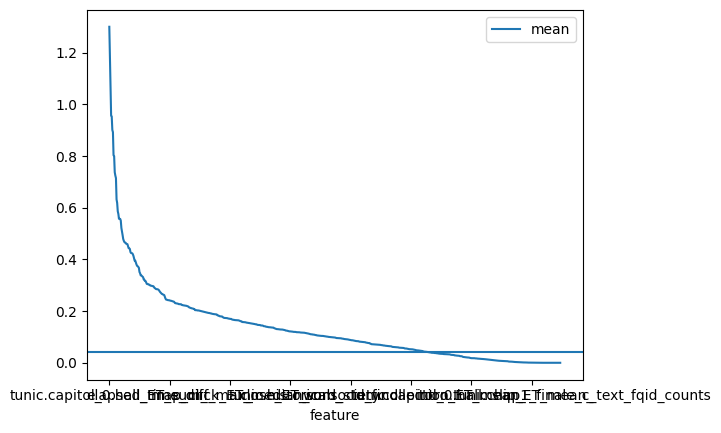

In [39]:
feature_importance_df.plot()
plt.axhline(feature_importance_df['mean'].quantile(q=0.3))

In [41]:
len(feature_importance_df)

748

In [42]:
feature_importance_df[feature_importance_df['mean'] <= feature_importance_df['mean'].quantile(q=0.3)]

,mean
feature,
boss_ET_mean_,0.042795
intro_ET_std_,0.042679
tunic.historicalsociety.closet.doorblock_ET_mean_,0.042631
tunic.historicalsociety.basement.janitor_ET_max_,0.042218
tunic.historicalsociety.closet.photo_ET_mean_,0.041776
...,...
word_median_wells,0.000000
word_need,0.000000
word_std_Oh,0.000000


In [47]:
word_feat = [c for c in feature_importance_df.index if 'word' in c]
feature_importance_df.loc[word_feat]

,mean
feature,
word_median_help,0.521900
word_std_notebook,0.509277
word_max_help,0.375377
word_median_you,0.346505
word_std_it,0.335862
...,...
word_median_wells,0.000000
word_need,0.000000
word_std_Oh,0.000000


<Axes: >

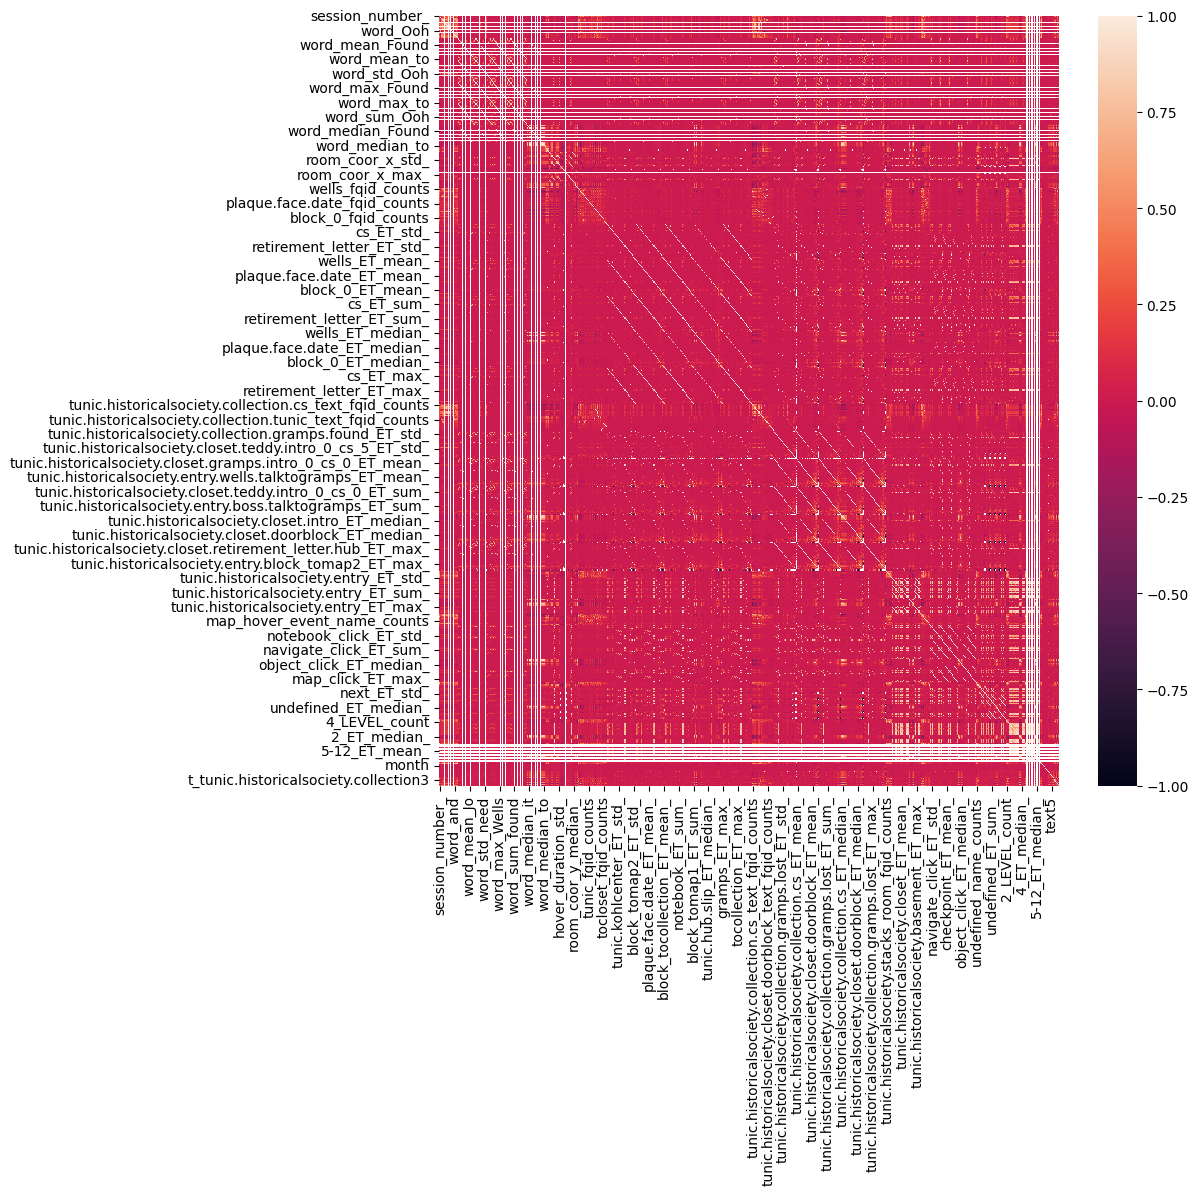

In [60]:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(train_x.corr())

In [63]:
cor = train_x.corr()
cor

,session_number_,word_that,word_this,word_it,word_you,word_find,word_found,word_Found,word_notebook,word_Wells,...,text5,t_fqid_directory,t_tunic.capitol_0.hall4,l_tunic.capitol_0.hall4,t_tunic.historicalsociety.collection3,l_tunic.historicalsociety.collection3,t_tunic.historicalsociety.entry1,l_tunic.historicalsociety.entry1,t_tunic.historicalsociety.collection2,l_tunic.historicalsociety.collection2
session_number_,1.000000,0.123579,0.208732,0.318459,0.387542,0.236466,NaN,0.291186,0.321115,0.308914,...,-0.014812,0.014116,0.085187,0.466227,0.206607,0.563458,0.018503,0.537663,0.022928,0.580659
word_that,0.123579,1.000000,-0.319105,0.090355,0.068173,-0.066872,NaN,0.342257,0.341033,0.407713,...,0.014301,0.020065,0.062538,0.061954,0.029820,0.042963,0.042599,0.183999,-0.017432,0.041489
word_this,0.208732,-0.319105,1.000000,0.541822,0.477499,0.443897,NaN,0.273827,0.331634,0.370760,...,0.014058,-0.013170,0.052877,0.074576,0.013683,0.062282,0.030060,0.184423,0.152315,0.587574
word_it,0.318459,0.090355,0.541822,1.000000,0.749521,0.305864,NaN,0.492998,0.475248,0.576935,...,0.035818,0.029411,0.113528,0.093826,0.062785,0.111967,0.110038,0.229331,0.150474,0.479335
word_you,0.387542,0.068173,0.477499,0.749521,1.000000,0.656794,NaN,0.331509,0.377531,0.408446,...,0.004435,0.047607,0.085671,0.119537,0.263493,0.486300,0.043376,0.228944,0.084793,0.469817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
l_tunic.historicalsociety.collection3,0.563458,0.042963,0.062282,0.111967,0.486300,0.391793,NaN,0.083662,0.101115,0.092436,...,-0.008808,0.037308,0.081500,0.191082,0.522303,1.000000,0.001178,0.196989,0.000484,0.236906
t_tunic.historicalsociety.entry1,0.018503,0.042599,0.030060,0.110038,0.043376,-0.009045,NaN,0.096650,0.042605,0.070521,...,0.241000,0.241943,0.465605,-0.087584,0.148564,0.001178,1.000000,-0.081626,0.492934,-0.020061
l_tunic.historicalsociety.entry1,0.537663,0.183999,0.184423,0.229331,0.228944,0.143272,NaN,0.334328,0.378796,0.380769,...,-0.081043,-0.019489,-0.133183,0.391077,-0.044974,0.196989,-0.081626,1.000000,-0.168671,0.459954
t_tunic.historicalsociety.collection2,0.022928,-0.017432,0.152315,0.150474,0.084793,0.056045,NaN,0.083606,0.035745,0.068269,...,0.262113,0.143982,0.518641,-0.103977,0.179560,0.000484,0.492934,-0.168671,1.000000,0.099109


In [65]:
np.where(cor.values > 0.7)

(array([  0,   0,   0, ..., 747, 747, 747]),
 array([  0, 169, 539, ..., 543, 684, 747]))

In [72]:
len(train_x.columns)

748

In [75]:
# null over 0.7 features
train_x.isna().sum()[train_x.isna().sum() / len(train_x) > 0.7].index

Index(['word_mean_found', 'word_mean_wells', 'word_mean_Oh', 'word_mean_flag',
       'word_std_found', 'word_std_wells', 'word_std_Oh', 'word_std_flag',
       'word_max_found', 'word_max_wells',
       ...
       '5-12_ET_mean_', '13-22_ET_mean_', '5-12_ET_sum_', '13-22_ET_sum_',
       '5-12_ET_median_', '13-22_ET_median_', '5-12_ET_max_', '13-22_ET_max_',
       'text1', 't_fqid_directory'],
      dtype='object', length=142)

In [89]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pca_components(df, features):
    df_scaled = StandardScaler().fit_transform(df[features].fillna(0))
    pcom = PCA(n_components=2).fit_transform(df_scaled)
    return pcom

pcom = pca_components(train_x, [col for col in train_x.columns if col not in train_x.isna().sum()[train_x.isna().sum() / len(train_x) > 0.7].index])
pcom


array([[-0.46700738,  1.51682354],
       [-0.63894281,  0.82237926],
       [-0.23975436,  6.9192912 ],
       ...,
       [-0.16633452, -2.24916493],
       [-0.48970159,  3.0809201 ],
       [ 0.36658185, -5.68509601]])

In [93]:
pcom[:,0], pcom[:,1]

(array([-0.46700738, -0.63894281, -0.23975436, ..., -0.16633452,
        -0.48970159,  0.36658185]),
 array([ 1.51682354,  0.82237926,  6.9192912 , ..., -2.24916493,
         3.0809201 , -5.68509601]))

Text(0, 0.5, 'pc2')

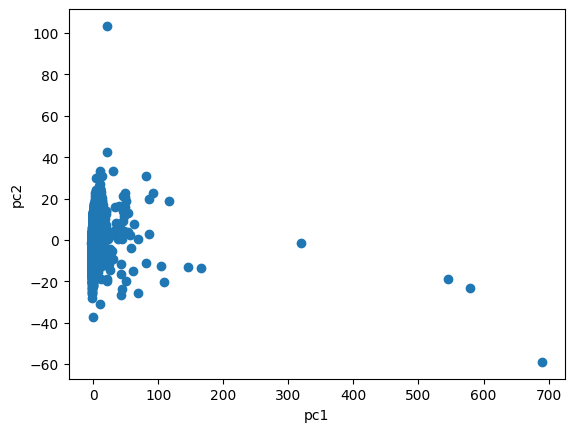

In [112]:
plt.scatter(pcom[:,0], pcom[:,1])
plt.xlabel('pc1')
plt.ylabel('pc2')
# plt.xlim(-10, 100)

In [144]:
outlier_users = train_x.reset_index().loc[pd.Series(pcom[:,0])[pd.Series(pcom[:,0]) > 8.62].index.values].session_id.values
np.save('../boosting/processed/outlier_users.npy', outlier_users)

: 

In [129]:
pd.Series(pcom[:,0]).quantile(0.99)

8.62085045555523

In [107]:
pd.DataFrame(train.iloc[18889]).T

,session_number_,word_that,word_this,word_it,word_you,word_find,word_found,word_Found,word_notebook,word_Wells,...,13-22_ET_max_,recap_reading,reading_cnt,year,month,day,hour,minute,second,id_anonymous
22010210032140300,453.0,4.0,11.0,35.0,38.0,10.0,5.0,0.0,0.0,4.0,...,21316.0,4.0,202.0,22.0,2.0,2.0,10.0,3.0,21.0,40300.0


In [109]:
old_train.loc[old_train.session_id == 22010210032140300]

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,...,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group,d_time,delt_time,in_the_same_dialogue
21659732,22010210032140300,490,1125433,navigate_click,undefined,13,NaN,326.517186,-263.590275,675.0,...,None,tunic.capitol_1.hall,None,0,0,1,13-22,-443456.0,0.0,False
21659733,22010210032140300,491,1125815,navigate_click,undefined,13,NaN,346.640797,-270.328467,676.0,...,None,tunic.capitol_1.hall,None,0,0,1,13-22,382.0,382.0,False
21659734,22010210032140300,492,1126213,navigate_click,undefined,13,NaN,395.529004,-279.840994,678.0,...,None,tunic.capitol_1.hall,None,0,0,1,13-22,398.0,398.0,False
21659735,22010210032140300,493,1127512,navigate_click,undefined,13,NaN,771.884372,-12.243596,838.0,...,toentry,tunic.capitol_1.hall,None,0,0,1,13-22,1299.0,1299.0,False
21659736,22010210032140300,494,1130909,map_click,undefined,13,NaN,477.297451,185.681611,571.0,...,tunic.historicalsociety,tunic.capitol_1.hall,None,0,0,1,13-22,3397.0,3397.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21660180,22010210032140300,938,1856865,map_hover,basic,22,NaN,NaN,NaN,NaN,...,tunic.drycleaner,tunic.historicalsociety.entry,None,0,0,1,13-22,445.0,445.0,False
21660181,22010210032140300,939,1859090,map_click,undefined,22,NaN,491.846508,17.289308,461.0,...,tunic.capitol_2,tunic.historicalsociety.entry,None,0,0,1,13-22,2225.0,2225.0,False
21660182,22010210032140300,940,1860540,navigate_click,undefined,22,NaN,236.311533,12.458602,412.0,...,chap4_finale_c,tunic.capitol_2.hall,None,0,0,1,13-22,1450.0,1450.0,False
21660183,22010210032140300,941,1861093,navigate_click,undefined,22,NaN,232.982789,35.413038,452.0,...,chap4_finale_c,tunic.capitol_2.hall,None,0,0,1,13-22,553.0,553.0,False


<Axes: xlabel='session_id'>

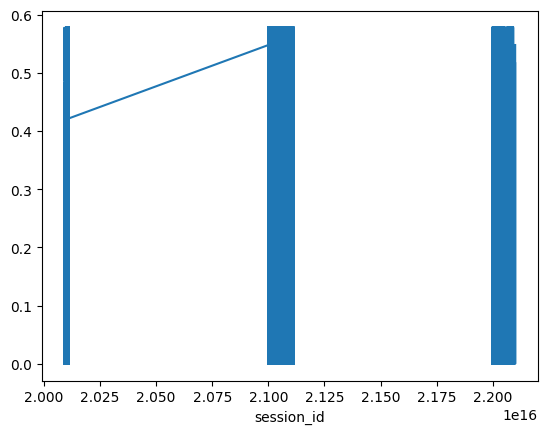

In [21]:
train['page_std_'].plot()
# 얼마나 많이 돌아갔냐를 지표로 나타내기 - 역전횟수!
# page당 횟수를 기록하기


In [23]:
train['page'].value_counts()

0.0    12918
1.0     1025
Name: page, dtype: int64

In [24]:
df['page'].value_counts()

5.0    101171
1.0     99900
6.0     90743
4.0     88197
0.0     73485
3.0     62565
2.0     48483
Name: page, dtype: int64